<a href="https://colab.research.google.com/github/joliveiraas/kvasir-seg/blob/main/UNET_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data

**Dataset**: *Kvasir-SEG*

Kvasir-SEG é um conjunto de dados de acesso aberto de imagens de pólipos gastrointestinais e máscaras de segmentação correspondentes, anotadas manualmente por um médico e depois verificadas por um gastroenterologista experiente.

Link: https://datasets.simula.no/kvasir-seg/

### 1.1 Data upload

In [ ]:
# Uploading data
import requests
import zipfile
from pathlib import Path

root = Path('root/')
data = root / 'data'

if not data.is_dir():
  data.mkdir(parents=True, exist_ok=True)

with open(root / 'data.zip', "wb") as f:
  request = requests.get('https://github.com/joliveiraas/kvasir-seg/raw/main/large%20data/kvasir-seg-large.zip')
  f.write(request.content)

  with zipfile.ZipFile(root / 'data.zip', 'r') as zip_ref:
    zip_ref.extractall(data)

In [ ]:
# Creating dir paths to store train and test data splits
train_imgs_path = data / 'train_images'
train_masks_path = data / 'train_masks'
test_imgs_path = data / 'test_images'
test_masks_path = data / 'test_masks'

In [ ]:
# Train and test split functions
import shutil

def train_split(source, folder, size):

    try:
        if not os.path.exists(folder):
          os.makedirs(folder)

        imgs_list = os.listdir(source)
        train_imgs_paths = imgs_list[:size]

        # Images
        for file in train_imgs_paths:
          source_path = os.path.join(source, file)
          folder_path = os.path.join(folder, file)
          shutil.copy2(source_path, folder_path)

        print('Copy completed successfully.')
    except Exception as e:
        print(f'Error')

def test_split(source, folder, size):

    try:
        if not os.path.exists(folder):
          os.makedirs(folder)

        imgs_list = os.listdir(source)
        test_imgs_paths = imgs_list[-size:]

        # Images
        for file in test_imgs_paths:
            source_path = os.path.join(source, file)
            folder_path = os.path.join(folder, file)
            shutil.copy2(source_path, folder_path)

        print('Copy completed successfully.')
    except Exception as e:
        print(f'Error')

In [ ]:
images = data / 'images'
masks =  data / 'masks'

In [ ]:
train_imgs = train_split(images, train_imgs_path, 800)
train_masks = train_split(masks, train_masks_path, 800)
test_imgs = test_split(images, test_imgs_path, 200)
test_masks = test_split(masks, test_masks_path, 200)

In [ ]:
# Remove 'images' and 'masks' folders
try:
  shutil.rmtree(images)
  print(f'The {images} folder was removed successfully.')
except OSError as e:
  print(f'Error: {e}')

try:
  shutil.rmtree(masks)
  print(f'The {masks} folder was removed successfully.')
except OSError as e:
  print(f'Error: {e}')

In [ ]:
# Walking through data (after split)
import os
for dirpath, dirnames, filenames in os.walk(root):
    print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'")

### 1.2 Dataset
> Building a class to turn data into Dataset class

> Visualizing data with matplotlib

In [ ]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import numpy as np

class KvasirDataset(Dataset):
  def __init__(self, image_dir, mask_dir, transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)
    self.masks = os.listdir(mask_dir)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img_path = os.path.join(self.image_dir, self.images[idx])
    mask_path = os.path.join(self.mask_dir, self.masks[idx])
    image = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path))
    #mask[mask == 255.0] = 1.0 # adjusting gray scale to use sigmoid later

    if self.transform is not None:
      augmentations = self.transform(image=image, mask=mask)
      image = augmentations["image"]
      mask = augmentations["mask"]

    return image, mask

Length of training data: 800


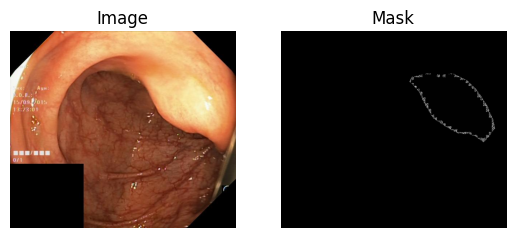

In [ ]:
# Visualizing data
import matplotlib.pyplot as plt
import random

datapoint = KvasirDataset(train_imgs_path, train_masks_path)
idx = random.randint(0, 80)
sample = datapoint.__getitem__(1)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(sample[0])
ax[0].set_title("Image")
ax[0].axis(False)
ax[1].imshow(sample[1], cmap="gray")
ax[1].set_title("Mask")
ax[1].axis(False)

print(f'Length of training data: {datapoint.__len__()}')

In [ ]:
sample[0].shape

(546, 626, 3)

In [ ]:
sample[1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

### 1.3 Data augmentation

PyTorch and Albumentations for image classification: https://albumentations.ai/docs/examples/pytorch_classification/

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMG_HEIGHT = 160
IMG_WIDTH = 240

# Train data
train_transform = A.Compose([
    A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH),
    #A.Rotate(limit=35, p=1.0),
    #A.HorizontalFlip(p=0.5),
    #A.VerticalFlip(p=0.1),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0
    ),
    ToTensorV2()
])

# Test data
test_transform = A.Compose([
    A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0
    ),
    ToTensorV2()
])

Original size: torch.Size([3, 160, 240]) -> [C, H, W]
Image permute: torch.Size([160, 240, 3]) -> [H, W, C]


(-0.5, 239.5, 159.5, -0.5)

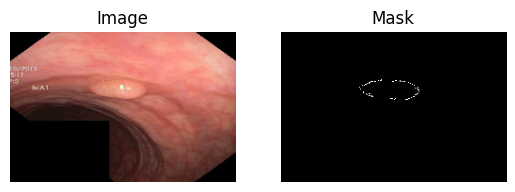

In [ ]:
train_ds = KvasirDataset(
      image_dir=train_imgs_path,
      mask_dir=train_masks_path,
      transform=train_transform
  )
random_idx = random.randint(0, 800)
img, mask = train_ds[random_idx][0], train_ds[random_idx][1]

img_permute = img.permute(1, 2, 0)
#mask_permute = mask.permute()

print(f'Original size: {img.shape} -> [C, H, W]')
print(f'Image permute: {img_permute.shape} -> [H, W, C]')

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img_permute)
ax[0].set_title("Image")
ax[0].axis(False)
ax[1].imshow(mask, cmap="gray")
ax[1].set_title("Mask")
ax[1].axis(False)

### 1.4 Dataloaders

In [ ]:
def get_loaders(
    train_dir,
    train_mask_dir,
    test_dir,
    test_mask_dir,
    batch_size,
    train_transform,
    test_transform,
    num_workers=2,
    pin_memory=True
):

  train_ds = KvasirDataset(
      image_dir=train_dir,
      mask_dir=train_mask_dir,
      transform=train_transform
  )

  train_loader = DataLoader(
      dataset=train_ds,
      batch_size=batch_size,
      num_workers=num_workers,
      pin_memory=pin_memory,
      shuffle=True
  )

  test_ds = KvasirDataset(
      image_dir = test_dir,
      mask_dir = test_mask_dir,
      transform=test_transform
  )

  test_loader=DataLoader(
      dataset=test_ds,
      batch_size=batch_size,
      num_workers=num_workers,
      pin_memory=pin_memory,
      shuffle=False
  )

  return train_loader, test_loader

In [ ]:
train_dataloader, test_dataloader = get_loaders(
    train_imgs_path,
    train_masks_path,
    test_imgs_path,
    test_masks_path,
    32,
    train_transform,
    test_transform
)

In [ ]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b760f653e80>,
 <torch.utils.data.dataloader.DataLoader at 0x7b760f651f30>)

In [ ]:
img, mask = next(iter(train_dataloader))

# Batch size vai ser 1 por enquanto, mas isso pode ser mudado
print(f'Image shape: {img.shape} -> [N, C, H, W]')
print(f'Label shape: {mask.shape}')

Image shape: torch.Size([32, 3, 160, 240]) -> [N, C, H, W]
Label shape: torch.Size([32, 160, 240])


### 2. Model
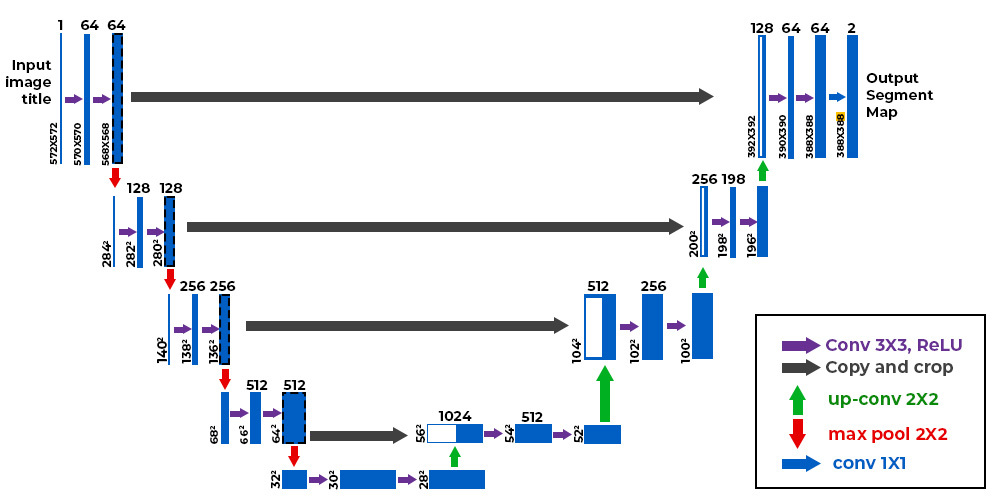

In [ ]:
import torch
from torch import nn
import torchvision.transforms.functional as TF

In [ ]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels=in_channels,
                  out_channels=out_channels,
                  kernel_size=3,
                  stride=1,
                  padding=1,
                  bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(in_channels=out_channels,
                  out_channels=out_channels,
                  kernel_size=3,
                  stride=1,
                  padding=1,
                  bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

  def forward(self, x):
    return self.conv(x)

In [ ]:
class UNET(nn.Module):
  def __init__(self, in_channels, out_channels, features=[64, 128, 256, 512]):
    super().__init__()

    self.downs = nn.ModuleList()
    self.ups = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # Downsampling layers
    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature)) # out_channels = feature
      in_channels = feature

    # Bridge layer
    self.bridge = DoubleConv(features[-1], features[-1]*2)

    # Upsampling layers
    for feature in reversed(features):
      self.ups.append(
          nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2) # adjust img's shape
      )
      self.ups.append(DoubleConv(feature*2, feature)) # apply conv block

    # Final output
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

  def forward(self, x):
    copy = list()

    # Downsampling
    for down in self.downs:
      x = down(x)
      copy.append(x)
      x = self.pool(x)

    # Bridge
    x = self.bridge(x)
    copy = copy[::-1] # mirroring the process

    # Upsampling
    for i in range(0, len(self.ups), 2):
      x = self.ups[i](x) # starts with ConvTransposed2d
      connection = copy[i//2] # track related conv connection

      if x.shape != connection.shape:
        x = TF.resize(x, size=connection.shape[2:]) # only height and width

      concat = torch.cat((connection, x), dim=1) # dim = 1 -> channels information
      x = self.ups[i+1](concat)

    return self.final_conv(x)

In [ ]:
# Testing model

def test():
  x = torch.randn(3, 1, 161, 161) # N, C, H, W
  model = UNET(in_channels=1, out_channels=1)
  preds = model(x)
  print(preds.shape)
  print(x.shape)
  assert preds.shape == x.shape

test()

torch.Size([3, 1, 161, 161])
torch.Size([3, 1, 161, 161])


# 3. Training



In [ ]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

### 3.1 Train function

In [ ]:
def train_fn(model: torch.nn.Module,
               train_dataloader,
               optimizer: torch.optim.Optimizer,
               loss_fn: torch.nn.Module,
               device: torch.device,
               scaler
               ):
  loop = tqdm(train_dataloader)

  model.train()

  for batch, (X, y) in enumerate(loop):
    X = X.to(DEVICE)
    y = y.float().unsqueeze(dim=1).to(DEVICE)

    with torch.cuda.amp.autocast():
      # 1. Forward pass
      y_logits = model(X)

      # 2. Loss
      loss = loss_fn(y_logits, y)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    scaler.scale(loss).backward()

    # 5. Optimizer step
    scaler.step(optimizer)

    scaler.update()
    loop.set_postfix(loss=loss.item())

  print(f'Train loss: {loss:.4f}')

Automatic mixed precision explanation ('with torch.cuda.amp.autocast()'): https://chat.openai.com/c/d6479248-bdc6-4c91-88a2-d1ea2c9ba236

### 3.2 Defining hyperparameters and math functions

In [ ]:
# Hyperparameters
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 32
LR = 1e-4
EPOCHS = 3
WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False

In [ ]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)
scaler = torch.cuda.amp.GradScaler()

### 3.3 Utils for training and evaluation loops

In [ ]:
# Accuracy function
def accuracy(loader, model, device=DEVICE):
  num_correct = 0
  num_pixels = 0
  dice_score = 0

  model.eval()

  with torch.inference_mode():
    for X, y in loader:
      X, y = X.to(device), y.unsqueeze(dim=1).to(device)
      logits = model(X)
      preds = torch.sigmoid(logits)
      preds = (preds > 0.7).float()
      num_correct += (preds == y).sum()
      num_pixels += torch.numel(preds)
      dice_score += (2 * (preds * y).sum()) / (
          (preds + y).sum() + 1e-8
      )

  print(f'Got {num_correct}/{num_pixels} correct | Acc: {num_correct/num_pixels*100:.2f}%')
  print(f'Dice score: {dice_score/len(loader)}')

In [ ]:
# Saving model functions
def save_checkpoint(state, filename="salvando.pth.tar"):
  print('=> Saving checkpoint')
  torch.save(state, filename)

def load_checkpoint(checkpoint, model):
  print('=> Loading checkpoint')
  model.load_state_dict(checkpoint['state_dict'])

In [ ]:
# Saving predictions images function
preds_imgs_folder = data / 'preds_masks'
if not preds_imgs_folder.is_dir():
  preds_imgs_folder.mkdir()

import torchvision
def save_pred_imgs(
    loader, model, device, folder
):
  model.eval()
  for i, (X, y) in enumerate(loader):
    X = X.to(device)
    with torch.inference_mode():
      preds = torch.sigmoid(model(X))
      preds = (preds > 0.5).float()

    torchvision.utils.save_image(
        preds, f'{folder}/pred_{i}.jpg'
    )

1. em 'preds = torch.sigmoid(model(X))' após fazer a predição, a função de ativação sigmoide será aplicada aos valores de pixel da máscara gerada;
2. em 'preds = (preds > 0.5).float()' todos os pixels da máscara gerada com valores > 0.5 vão ser rotulados como 1 (True) e os outros como 0 (False);
3. em 'num_correct += (preds == y).sum()' irá contar quantos pixels o modelo acertou com base na máscara verdadeira;
4. por fim, em 'num_pixels += torch.numel(preds)' retorna o total de pixels da máscara gerada.

obs: 'dice_score' é uma métrica criada para calcular acurácia em problemas de segmentação binária.

In [ ]:
test = torch.arange(0, 10)
test = (test > 3).float()
print(test)

tensor([0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])


In [ ]:
a = torch.arange(0, 10)
torch.numel(a)

10

### 3.4 Training loop

In [ ]:
# Training loop
torch.cuda.manual_seed(42)

for epoch in range(EPOCHS):
  print(f'Epoch: {epoch}')
  train_fn(model,
           train_dataloader,
           optimizer,
           loss_fn,
           DEVICE,
           scaler)

  checkpoint = {
      'state_dict': model.state_dict(),
      'optimizer': optimizer.state_dict()
  }
  save_checkpoint(checkpoint)

  ### Checking accuracy
  accuracy(test_dataloader, model, DEVICE)

  ### Printing same examples to a folder
  save_pred_imgs(test_dataloader, model, DEVICE, folder=preds_imgs_folder)

Epoch: 0


  0%|          | 0/25 [00:00<?, ?it/s]

Train loss: -2.2297
=> Saving checkpoint
Got 6347696/7680000 correct | Acc: 82.65%
Dice score: 0.14402854442596436
Epoch: 1


  0%|          | 0/25 [00:00<?, ?it/s]

Train loss: -4.7129
=> Saving checkpoint
Got 6109147/7680000 correct | Acc: 79.55%
Dice score: 1.1032018661499023
Epoch: 2


  0%|          | 0/25 [00:00<?, ?it/s]

Train loss: -7.3613
=> Saving checkpoint
Got 6084598/7680000 correct | Acc: 79.23%
Dice score: 1.2716503143310547


 ### Saving model
  checkpoint = {
      'state_dict': model.state_dict(),
      'optimizer': optimizer.state_dict()
  }
  save_checkpoint(checkpoint)

def train_fn(model: torch.nn.Module,
               train_dataloader,
               optimizer: torch.optim.Optimizer,
               loss_fn: torch.nn.Module,
               device: torch.device,
               scaler
               ):
  loop = tqdm(train_dataloader)

  model.train()

  for batch, (X, y) in enumerate(loop):
    X = X.to(DEVICE)
    y = y.float().unsqueeze(dim=1).to(DEVICE)

    with torch.cuda.amp.autocast():
      # 1. Forward pass
      y_logits = model(X)

      # 2. Loss
      loss = loss_fn(y_logits, y)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    scaler.scale(loss).backward()

    # 5. Optimizer step
    scaler.step(optimizer)

    scaler.update()
    loop.set_postfix(loss=loss.item())

  print(f'Train loss: {loss:.4f}')

# Accuracy function
def accuracy(loader, model, device=DEVICE):
  num_correct = 0
  num_pixels = 0
  dice_score = 0

  model.eval()

  with torch.inference_mode():
    for X, y in loader:
      X, y = X.to(device), y.unsqueeze(dim=1).to(device)
      preds = torch.sigmoid(model(X))
      preds = (preds > 0.5).float()
      num_correct += (preds == y).sum()
      num_pixels += torch.numel(preds)
      dice_score += (2 * (preds * y).sum()) / (
          (preds + y).sum() + 1e-8
      )

  print(f'Got {num_correct}/{num_pixels} correct | Acc: {num_correct/num_pixels*100:.2f}%')
  print(f'Dice score: {dice_score/len(loader)}')